<a href="https://colab.research.google.com/github/scardenol/RP_argos/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and prefs

In [220]:
import sympy as sp
import numpy as np

import pandas as pd # Modin to use pandas in a multi-core way
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt #gráficas
import matplotlib as mpl
import seaborn as sns #gráficas
plt.style.use('ggplot') #estilo de graficas

# Read Data

In [221]:
url = 'https://github.com/scardenol/RP_argos/blob/main/cement_data.xlsx?raw=true' # Raw link
data = pd.read_excel(io=url, sheet_name='Sheet1')
data.pop(data.columns[0]);
data.head(3)

,Fecha,Tipo Cemento,< 3um,3-30 um,>30 um,Blaine,Ret 325,Cons Normal,F Inicial,F Final,Cons Agua,Fluidez,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,K2O,Na2O,P Ignea,Cal libre,EA,Adición caliza,Tiempo,Resistencia
0,2019-11-04,1,25.49,69.26,5.25,4846.0,1.5,26.77,94.0,190.0,350.0,111.10,19.28,4.5,3.29,62.82,2.91,2.59,0.23,0.31,4.07,1.73,0.46134,0.11284,1,16.96
1,2019-11-04,1,25.49,69.26,5.25,4846.0,1.5,26.77,94.0,190.0,350.0,111.08,19.28,4.5,3.29,62.82,2.91,2.59,0.23,0.31,4.07,1.73,0.46134,0.11334,3,25.59
2,2019-11-04,1,25.49,69.26,5.25,4846.0,1.5,26.77,94.0,190.0,350.0,111.08,19.28,4.5,3.29,62.82,2.91,2.59,0.23,0.31,4.07,1.73,0.46134,0.11334,7,26.44


In [222]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988 entries, 0 to 2987
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Fecha           2988 non-null   datetime64[ns]
 1   Tipo Cemento    2988 non-null   int64         
 2   < 3um           2988 non-null   float64       
 3   3-30 um         2988 non-null   float64       
 4   >30 um          2988 non-null   float64       
 5   Blaine          2988 non-null   float64       
 6   Ret 325         2988 non-null   float64       
 7   Cons Normal     2988 non-null   float64       
 8   F Inicial       2988 non-null   float64       
 9   F Final         2988 non-null   float64       
 10  Cons Agua       2988 non-null   float64       
 11  Fluidez         2988 non-null   float64       
 12  SiO2            2988 non-null   float64       
 13  Al2O3           2988 non-null   float64       
 14  Fe2O3           2988 non-null   float64       
 15  CaO 

In [223]:
data.describe()

,Tipo Cemento,< 3um,3-30 um,>30 um,Blaine,Ret 325,Cons Normal,F Inicial,F Final,Cons Agua,Fluidez,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,K2O,Na2O,P Ignea,Cal libre,EA,Adición caliza,Tiempo,Resistencia
count,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000
mean,0.879853,21.784587,71.741754,6.398763,4756.762125,0.995865,26.759882,112.104247,216.878226,354.890044,110.211673,20.133334,4.502215,3.057305,62.560509,2.435672,2.691496,0.204898,0.108033,4.117379,1.092806,0.242816,0.090984,9.768742,33.334146
std,0.325188,2.691147,4.352730,2.132732,320.432091,0.729051,0.697346,19.706644,23.518137,5.770927,2.750848,0.506143,0.147388,0.164173,0.831426,0.294099,0.252173,0.027271,0.095993,0.832241,0.319576,0.104367,0.036096,10.765467,11.475799
min,0.000000,2.280000,7.700000,0.000000,3915.000000,0.090000,24.770000,62.000000,117.000000,340.000000,105.000000,18.760000,4.100000,2.120000,59.690000,1.840000,1.890000,0.020000,0.000000,1.410000,0.480000,0.066320,0.020000,1.000000,3.010000
25%,1.000000,20.250000,69.417500,5.210000,4520.000000,0.270000,26.310000,100.000000,200.000000,352.000000,108.000000,19.837500,4.410000,2.950000,62.090000,2.240000,2.540000,0.190000,0.050000,3.620000,0.890000,0.175020,0.070000,3.000000,24.047500
50%,1.000000,22.120000,71.668350,6.288700,4730.000000,0.940000,26.770000,111.000000,220.000000,354.000000,110.460000,20.210000,4.520000,3.040000,62.600000,2.390000,2.690000,0.200000,0.060000,4.140000,1.030000,0.194760,0.090000,7.000000,33.800000
75%,1.000000,23.280000,74.290000,7.240000,4969.000000,1.610000,27.230000,124.000000,230.000000,357.000000,112.000000,20.450000,4.610000,3.170000,63.070000,2.580000,2.820000,0.220000,0.140000,4.730000,1.210000,0.287920,0.106250,28.000000,43.097500
max,1.000000,31.910000,92.020000,28.330000,6041.000000,2.910000,31.380000,172.000000,330.000000,380.000000,115.000000,22.030000,4.880000,3.880000,67.270000,3.550000,3.790000,0.280000,0.950000,6.840000,2.460000,1.081600,0.400000,28.000000,57.630000


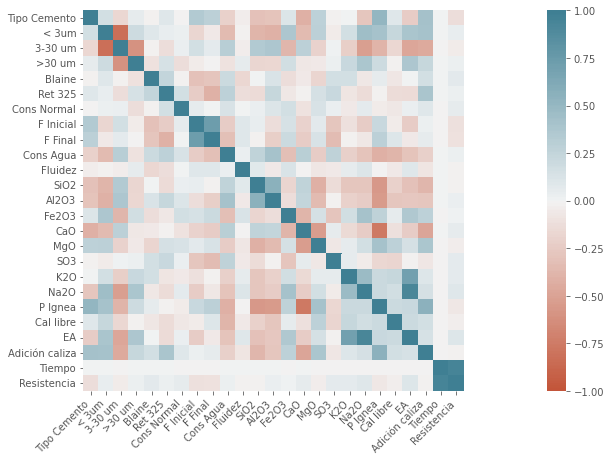

In [224]:
plt.figure(figsize = (30, 7))

corr = data.corr(method = 'spearman')
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [225]:
corr['Resistencia'].sort_values()

Tipo Cemento     -0.120514
F Inicial        -0.115945
F Final          -0.106363
P Ignea          -0.067376
3-30 um          -0.046401
MgO              -0.037976
Cal libre        -0.024407
Adición caliza   -0.016970
Fluidez          -0.010661
SiO2             -0.010151
Fe2O3             0.010001
>30 um            0.025217
Cons Agua         0.028711
Ret 325           0.029028
Al2O3             0.034823
< 3um             0.045486
CaO               0.050709
Cons Normal       0.060971
K2O               0.063065
SO3               0.068290
Blaine            0.070475
Na2O              0.100843
EA                0.107117
Tiempo            0.950424
Resistencia       1.000000
Name: Resistencia, dtype: float64

In [226]:
data.loc[:, 'Tipo Cemento'] = data['Tipo Cemento'].map(lambda s:'UEM' if s == 1 else 'IND') # Cement type map: {0,1} -> {IND, UEM}
data.groupby(['Tipo Cemento']).size() # Samples per cement type

Tipo Cemento
IND     359
UEM    2629
dtype: int64

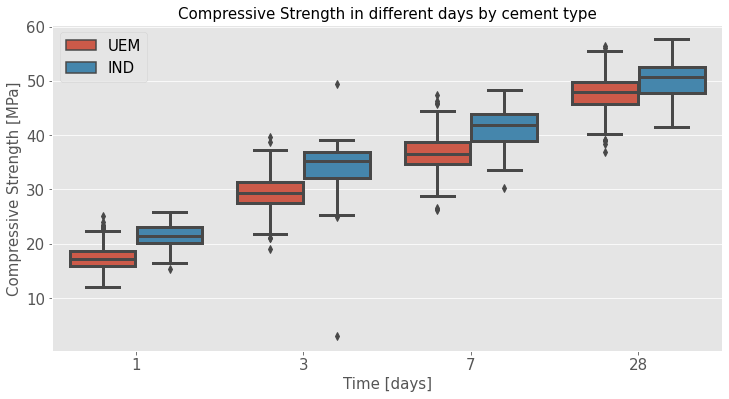

In [227]:
plt.figure(figsize = (12, 6));
sns.boxplot(x= 'Tiempo', y = 'Resistencia', data = data, hue = 'Tipo Cemento', linewidth = 3);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.xlabel('Time [days]', fontsize = 15);
plt.ylabel('Compressive Strength [MPa]', fontsize = 15);
plt.legend(fontsize = 15);
plt.title('Compressive Strength in different days by cement type', fontsize = 15);

In [228]:
data_UEM = data[data['Tipo Cemento'] == 'UEM'].reset_index(drop=True) # Retrieval of UEM sample
data_UEM.head(3)

,Fecha,Tipo Cemento,< 3um,3-30 um,>30 um,Blaine,Ret 325,Cons Normal,F Inicial,F Final,Cons Agua,Fluidez,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,K2O,Na2O,P Ignea,Cal libre,EA,Adición caliza,Tiempo,Resistencia
0,2019-11-04,UEM,25.49,69.26,5.25,4846.0,1.5,26.77,94.0,190.0,350.0,111.10,19.28,4.5,3.29,62.82,2.91,2.59,0.23,0.31,4.07,1.73,0.46134,0.11284,1,16.96
1,2019-11-04,UEM,25.49,69.26,5.25,4846.0,1.5,26.77,94.0,190.0,350.0,111.08,19.28,4.5,3.29,62.82,2.91,2.59,0.23,0.31,4.07,1.73,0.46134,0.11334,3,25.59
2,2019-11-04,UEM,25.49,69.26,5.25,4846.0,1.5,26.77,94.0,190.0,350.0,111.08,19.28,4.5,3.29,62.82,2.91,2.59,0.23,0.31,4.07,1.73,0.46134,0.11334,7,26.44


In [229]:
# X = data_UEM.iloc[:,2:-1] # Ignore first 2 columns and last column to get predictors (x1, x2, ..., xn)
training_data = data_UEM.sample(frac=0.1, random_state=25) # frac = proportion, random_state = seed
testing_data = data_UEM.drop(training_data.index)

# Retrieve X and Y data for training
# X_training = training_data[['Tiempo', 'EA', 'Na2O', 'F Inicial', 'P Ignea']] # Retrieve the predictors x1, x2, ..., xn
X_training = training_data[['Tiempo', 'EA', 'F Inicial']]
Y_training = training_data['Resistencia'] # Retrieve the Y variable

# Retrieve X and Y data for testing
# X_testing = training_data[['Tiempo', 'EA', 'Na2O', 'F Inicial', 'P Ignea']] # Retrieve the predictors x1, x2, ..., xn
X_testing = testing_data[['Tiempo', 'EA', 'F Inicial']]
Y_testing = training_data['Resistencia'] # Retrieve the Y variable

# Convert training X and Y to lists
X_training_list = [X_training.iloc[:,i].tolist() for i in range(X_training.shape[1])]
Y_training_list = Y_training.iloc[:].tolist()

# Convert testing X and Y to lists
X_training_list = [X_training.iloc[:,i].tolist() for i in range(X_training.shape[1])]
Y_training_list = Y_training.iloc[:].tolist()

# Model

## Functions

In [230]:
import sympy as sp
from sympy import symbols, init_printing, Function, sympify, Derivative, simplify, ordered
from sympy import factorial, Matrix, prod
init_printing(use_latex='mathjax') # Printing preferences
import itertools


def Taylor_polynomial_sympy(function_expression: 'symbolic', variable_list: 'list', evaluation_point: 'list', degree: 'int') -> 'symbolic':

  n_var = len(variable_list)
  point_coordinates = [(i, j) for i, j in (zip(variable_list, evaluation_point))]  # list of tuples with variables and their evaluation_point coordinates, to later perform substitution

  deriv_orders = list(itertools.product(range(degree + 1), repeat=n_var))  # list with exponentials of the partial derivatives
  deriv_orders = [deriv_orders[i] for i in range(len(deriv_orders)) if sum(deriv_orders[i]) <= degree]  # Discarding some higher-order terms
  n_terms = len(deriv_orders)
  deriv_orders_as_input = [list(sum(list(zip(variable_list, deriv_orders[i])), ())) for i in range(n_terms)]  # Individual degree of each partial derivative, of each term

  polynomial = 0
  for i in range(n_terms):
    partial_derivatives_at_point = function_expression.diff(*deriv_orders_as_input[i]).subs(point_coordinates)  # e.g. df/(dx*dy**2)
    denominator = prod([factorial(j) for j in deriv_orders[i]])  # e.g. (1! * 2!)
    distances_powered = prod([(Matrix(variable_list) - Matrix(evaluation_point))[j] ** deriv_orders[i][j] for j in range(n_var)])  # e.g. (x-x0)*(y-y0)**2
    polynomial += partial_derivatives_at_point / denominator * distances_powered
  return polynomial



def Model_taylor_sympy(taylor_serie: 'symbolic') -> (['symbolic'], ['symbolic']):

  # Convert Serie to list
  S = list(sympify((sympify(taylor_serie, evaluate=False)).args))
  M = S.copy() # Copy the list to use for the model

  # Check for derivatives
  # Substitue derivatives from Serie List with parameters (cleaner than from Serie)
  d = [list(i.atoms(Derivative)) for i in M]
  d_unpacked = [x for l in d for x in l] # this unpacks it but gets messy if a list had more than 1 element
  
  # if d_unpacked is empty it means there are no derivatives in the serie
  A = [];

  if len(d_unpacked) != 0:  # if there are derivatives
    indexes = [idx for idx in range(len(d)) if len(d[idx])] # Get indexes

    for i in indexes:
      A_aux = sympify(['a' + str(_) for _ in range(len(A), len(A) + 1)])
      A += A_aux
      M[i] = simplify(M[i].subs(list(ordered(d[i]))[0], A_aux[0]))
    
    # Clean the f(c) termn at the end
    A_aux = sympify(['a' + str(_) for _ in range(len(A), len(A) + 1)])
    A += A_aux
    M[-1] = A_aux[0]
  
  return M, A

## Implementation

In [231]:
# Model F(x1, x2, ..., xn) where n is n_vars

n_vars = X_training.shape[1] # Num of variables = num of columns
vars = sp.symbols('x0:'+str(n_vars)) # List of variables
center = [0]*len(vars)

f = Function('f')
fun = f(sum(vars)) # f(x1+x2+...+xn)
deg = 2

F = Taylor_polynomial_sympy(fun, vars, center, deg)

# Generate the model
M, A = Model_taylor_sympy(F)

In [232]:
# Display results

display(A) # List of all parameters

# Convert list back to sum
model = sum(M)
display(model)

[a₀, a₁, a₂, a₃, a₄, a₅, a₆, a₇, a₈, a₉]

                             2        2        2                              
                        a₃⋅x₀    a₄⋅x₁    a₅⋅x₂                               
a₀⋅x₀ + a₁⋅x₁ + a₂⋅x₂ + ────── + ────── + ────── + a₆⋅x₀⋅x₁ + a₇⋅x₀⋅x₂ + a₈⋅x₁
                          2        2        2                                 

        
        
⋅x₂ + a₉
        

In [233]:
par = list(vars) + A
display(par) # Order of function parameters
fun = sp.lambdify(par, model, 'numpy')

[x₀, x₁, x₂, a₀, a₁, a₂, a₃, a₄, a₅, a₆, a₇, a₈, a₉]

# Genetic Algorithm

## Functions

In [239]:
import numpy as np
import random
np.random.seed(42)

# array: np.array, [list, ..., list], list

def generate_population(P_size: 'tuple') -> 'array':
  P = 1*np.random.chisquare(df=1, size=P_size) # Initial population
  return P.tolist()

def mse(A: 'array', B: 'array') -> float: # Cleanest way to calculate MSE
  return np.square(np.subtract(A, B)).mean()

def fitness(X: 'array', Y: list, P: 'array', fun: 'function') -> list:
  '''
  X = [X1, X2, ..., Xn]: observations of predictors
  Y: observations of variable of interest
  P = [theta1, theta2, ..., thetan]: population (possible parameters)
  '''
  Y_bar = [[fun(*[item[i] for item in X], *P[j]) for i in range(len(X[0]))] for j in range(len(P))]
  fitness = [mse(Y_bar[i], Y) for i in range(len(P))]
  return fitness, Y_bar

def selection(P: 'array', fitness: list) -> 'array':
  return random.choices(population=P, weights=fitness, k=2)

def crossover(x: list, y: list) -> 'Tuple' : # Single point
  if len(x) != len(y):
    raise ValueError("Parents x and y need to be of same length")

  length = len(x)

  if length < 2:
    return x, y

  p = random.randint(0, length-1)
  return x[0:p] + y[p:], y[0:p] + x[p:]

def mutation(x: list, probability: float, num: int) -> list:
  for _ in range(num):
    index = random.randrange(len(x))
    value = random.randint(1,2)*np.random.uniform(-1.0, 1.0, 1) # Uniform mutation
    x[index] = x[index] if random.random() > probability else x[index] + value[0]
  return x


## Implementation

In [268]:
def fun(x0, x1, x2, a0, a1, a2, b):
  return (a0*x0 + a1*x1 + a2*x2 + b)

# Inputs of the equation
X = X_training_list

# Compressive Strength
Y = Y_training_list

import time
start = time.time()
m_prob = 0.5 # Probabilidad de mutación 
P = generate_population((20,4)) # (individuos, parámetros)
generations = 1000

for i in range(generations):
  fit, _ = fitness(X,Y,P,fun)
  P = [a for _, a in sorted(zip(fit, P))] # Ordena la población de menor a mayor fitness
  
  next_generation = P[0:2] # Guarda los 2 mejores

  for j in range(int(len(P) / 2) - 1):
    parents = selection(P,fit)
    x, y = crossover(parents[0], parents[1])
    x = mutation(x, m_prob, 3)
    next_generation += [x,y]

  P = next_generation
  fit, Y_bar = fitness(X,Y,P,fun)
  P = [a for _, a in sorted(zip(fit, P))] # Ordena la población de menor a mayor fitness
  current_time = time.time()-start
  minutes = round((current_time // 60) % 60, 0)
  seconds = round(current_time % 60, 0)
  print('Generation: ', str(i))
  print('time: ', int(minutes), "m", int(seconds), "s")
  print(f'Fitness: {fit[0]}')

print(f'best solution: {P[0]}')
print(f'Fitness: {fit[0]}')
print(f'Y_hat: {Y_bar[0]}')

Generation:  0
time:  0 m 0 s
Fitness: 55.771493928567125
Generation:  1
time:  0 m 0 s
Fitness: 55.771493928567125
Generation:  2
time:  0 m 0 s
Fitness: 55.771493928567125
Generation:  3
time:  0 m 0 s
Fitness: 55.771493928567125
Generation:  4
time:  0 m 0 s
Fitness: 55.771493928567125
Generation:  5
time:  0 m 0 s
Fitness: 55.771493928567125
Generation:  6
time:  0 m 0 s
Fitness: 55.771493928567125
Generation:  7
time:  0 m 0 s
Fitness: 55.771493928567125
Generation:  8
time:  0 m 0 s
Fitness: 55.771493928567125
Generation:  9
time:  0 m 1 s
Fitness: 55.771493928567125
Generation:  10
time:  0 m 1 s
Fitness: 55.771493928567125
Generation:  11
time:  0 m 1 s
Fitness: 55.771493928567125
Generation:  12
time:  0 m 1 s
Fitness: 55.771493928567125
Generation:  13
time:  0 m 1 s
Fitness: 55.771493928567125
Generation:  14
time:  0 m 1 s
Fitness: 55.771493928567125
Generation:  15
time:  0 m 1 s
Fitness: 55.771493928567125
Generation:  16
time:  0 m 1 s
Fitness: 55.771493928567125
Generat

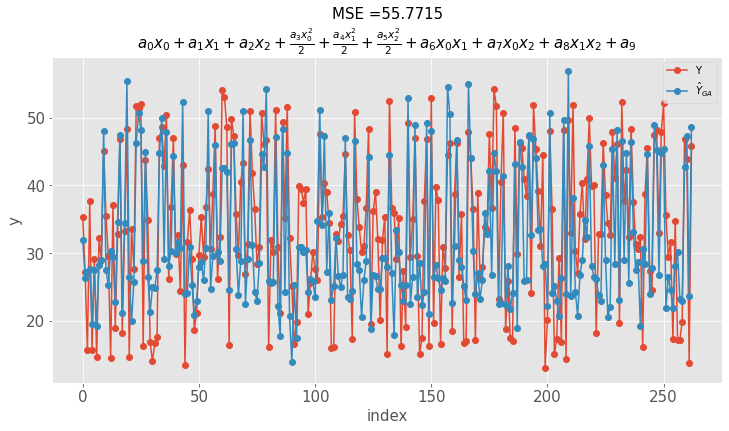

In [269]:
mse_GA = mse(Y_bar[0],Y)
T = list(range(len(Y)))

# Plot data and results
plt.figure(figsize = (12, 6));
plt.plot(T, Y, '-o', label='Y')
plt.plot(T, Y_bar[0], '-o', label='$\hat{Y}_{GA}$')
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.xlabel('index', fontsize = 15);
plt.ylabel('y', fontsize = 15);
plt.legend()
plt.title('MSE =' + str(round(mse_GA, 4)) + '\n' + '$'+f'{sp.latex(model)}'+'$', fontsize = 15);

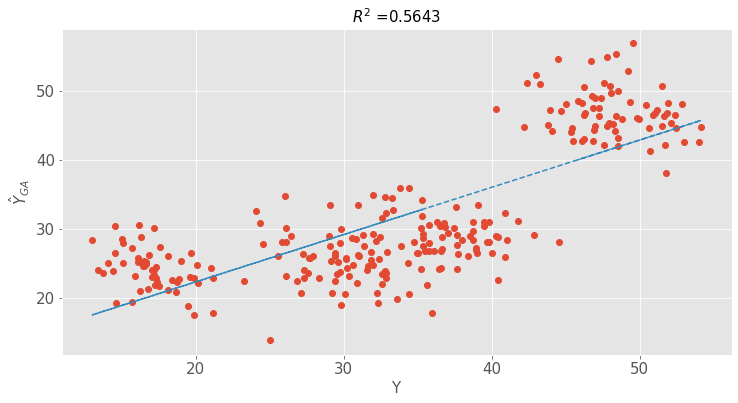

In [270]:
# Plot model fit

plt.figure(figsize = (12, 6));
plt.plot(Y, Y_bar[0], 'o')
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.xlabel('Y', fontsize = 15);
plt.ylabel('$\hat{Y}_{GA}$', fontsize = 15);
RES = sum([(Y[i] - Y_bar[0][i])**2 for i in range(len(Y))]) # residual error
TOT = sum([(Y[i] - np.mean(Y))**2 for i in range(len(Y))]) # total error
R2 = 1-(RES/TOT) # definition of R2 metric
plt.title('$R^2$ =' + str(round(R2, 4)), fontsize = 15);

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(Y, Y_bar[0], 1);

#add linear regression line to scatterplot 
plt.plot(Y, [m*i+b for i in Y], '--');